## Import libraries

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns

from CinePred.data.importing import import_data
from CinePred.data.preprocessing import *
from CinePred.data.featuring import *
from CinePred.pipeline import *
from CinePred.baseline import *

from CinePred import pipeline
from CinePred import baseline
from CinePred import new_model
from CinePred.new_model import *



from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_validate
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer, RobustScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn import set_config; set_config(display='diagram')

import datetime
sns.set(rc={'figure.figsize':(16,8)})
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Data

In [20]:
df = import_data(link = '../raw_data/IMDb_movies.csv')
df.head(1)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0


In [21]:
df_preproc = preproc(df, path='../raw_data/cat_acteur.csv')
df_preproc.head(1)

,imdb_title_id,actors,description,avg_vote,country,title,worlwide_gross_income,year,duration,budget,production_company,director,writer,shifted,date_sin,date_cos,Action,Biography,Thriller,Crime,Drama,Adventure,Romance,Western,Documentary,Musical,Film-Noir,Fantasy,Mystery,Sport,History,War,Horror,Family,Music,Sci-Fi,Animation,Comedy,Nb_actuals_movie_directors_company,Nb_actuals_movie_directors,Nb_actuals_movie_directors_writer
0,tt6793280,"Lalor Roddy, Ciaran Flynn, Helena Bereen, Laur...","In the fall of 1960, Father Thomas Riley and F...",5.2,"Ireland, UK",The Devil's Doorway,5.713205,2018,76,0.013124,23ten,Aislinn Clarke,"Martin Brennan, Aislinn Clarke",0,0.866025,0.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1


In [22]:
def test(director,year,main_actor,second_actor,third_actor,writer,production_company,date_published,genre,duration,budget,title =''):

    #----   Init Dataframe ----#
    df=pd.DataFrame({'year':[year]})
    df['year'] = year
    df['duration'] = duration
    df['budget'] = budget*1000000
    df['genre'] = genre
    df['director'] = director
    df['writer'] = writer
    df['production_company'] = production_company
    df['actors'] = f'{main_actor}, {second_actor}, {third_actor}'
    df['date_published'] = date_published
    
    #----   preproc   ----#
    df['year'] = convert_to_int(df[['year']])
    df['duration'] = convert_to_int(df[['duration']])
    df['budget'] = log_transformation(df[['budget']])

    actors_1 = df_preproc[['shifted','actors']][df_preproc[['shifted','actors']]['actors'].str.contains(main_actor)].max()['shifted']
    actors_2 = df_preproc[['shifted','actors']][df_preproc[['shifted','actors']]['actors'].str.contains(second_actor)].max()['shifted']
    actors_3 = df_preproc[['shifted','actors']][df_preproc[['shifted','actors']]['actors'].str.contains(third_actor)].max()['shifted']
    shifted = actors_1 + actors_2 + actors_3
    df['shifted'] = shifted
  
    df['date_published'] = convert_to_date(df[['date_published']])
    df['date_sin'] = add_sin_features(df[['date_published']])
    df['date_cos'] = add_cos_features(df[['date_published']])
    df.drop(columns='date_published', inplace=True)

    ohe = GenreOHE()
    ohe.fit(df) # la colonne 'genre' est spécifié dans la classe
    df = ohe.transform(df)
    
    df['Nb_actuals_movie_directors_company'] = df_preproc[['Nb_actuals_movie_directors_company','production_company']][df_preproc[['Nb_actuals_movie_directors_company','production_company']]['production_company'].str.contains(production_company)].max()['Nb_actuals_movie_directors_company']
    df['Nb_actuals_movie_directors'] = df_preproc[['Nb_actuals_movie_directors','director']][df_preproc[['Nb_actuals_movie_directors','director']]['director'].str.contains(director)].max()['Nb_actuals_movie_directors']
    df['Nb_actuals_movie_directors_writer'] = df_preproc[['Nb_actuals_movie_directors_writer','writer']][df_preproc[['Nb_actuals_movie_directors_writer','writer']]['writer'].str.contains(writer)].max()['Nb_actuals_movie_directors_writer']
    
    df = df.drop(columns=['actors'])
    
    df = df.drop(columns=['production_company','director','writer'])
    #----   Prediction   ----#
    model = load_model("model.joblib")
    result = predict_fromX(model,df)
    
    return result


In [23]:
test(
    director='Steven Spielberg',
    year=2022,
    main_actor='Brad Pitt',
    second_actor='Jean Dujardin',
    third_actor='Brad Pitt',
    writer='Woody Allen',
    production_company='Walt Disney Pictures',
    date_published='2021-12-12',
    genre='Drama',
    duration=60,
    budget=1
)

823683.7860490824

In [24]:
df_preproc = df_preproc.drop(columns=['production_company', 'director', 'writer'])
df_preproc = df_preproc.drop(columns=['imdb_title_id','actors','description','avg_vote','country','title'])
df_preproc.head(1)
  

,worlwide_gross_income,year,duration,budget,shifted,date_sin,date_cos,Action,Biography,Thriller,Crime,Drama,Adventure,Romance,Western,Documentary,Musical,Film-Noir,Fantasy,Mystery,Sport,History,War,Horror,Family,Music,Sci-Fi,Animation,Comedy,Nb_actuals_movie_directors_company,Nb_actuals_movie_directors,Nb_actuals_movie_directors_writer
0,5.713205,2018,76,0.013124,0,0.866025,0.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1


## Cleaning and creating X and y

In [25]:
df = import_data(path = 'raw_data/IMDb movies.csv')

# Prepare
print("----- CLEAN DATA ------")
df_preproc = preproc(df)

print("----- GET FITTED MODEL ------")
model = get_fitted_model(df_preproc)

print("----- SAVE MODEL ------")
save_model(model, "model.joblib")

print("----- LOAD MODEL ------")
model = load_model("model.joblib")

print("----- PREDICT MODEL ------")
prediction = predict_fromX(
model,df_preproc.head(1).drop(columns='worlwide_gross_income'))
print(prediction)

TypeError: import_data() got an unexpected keyword argument 'path'

<AxesSubplot:xlabel='worlwide_gross_income', ylabel='Count'>

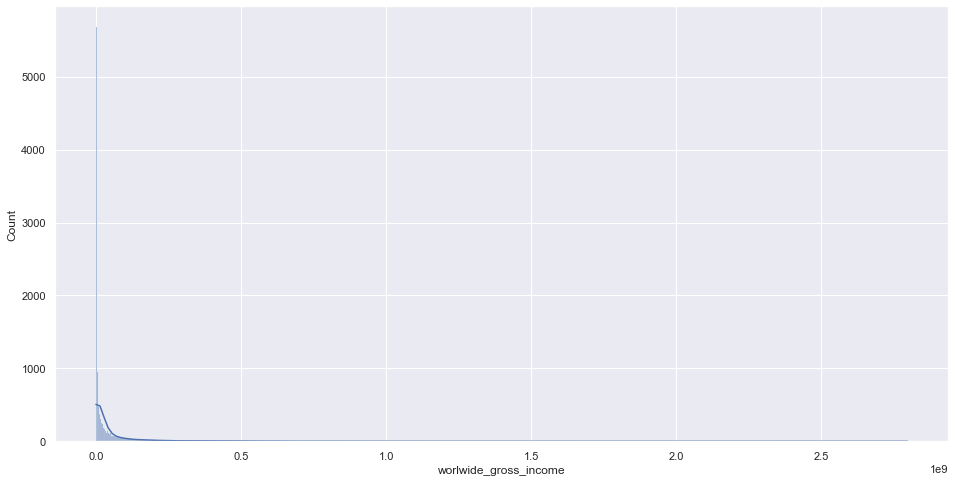

In [53]:
# Plot Y distribution

sns.set(rc={'figure.figsize':(16,8)})
sns.histplot(df_sample['worlwide_gross_income'], kde=True, edgecolor='w')

<AxesSubplot:xlabel='worlwide_gross_income', ylabel='Count'>

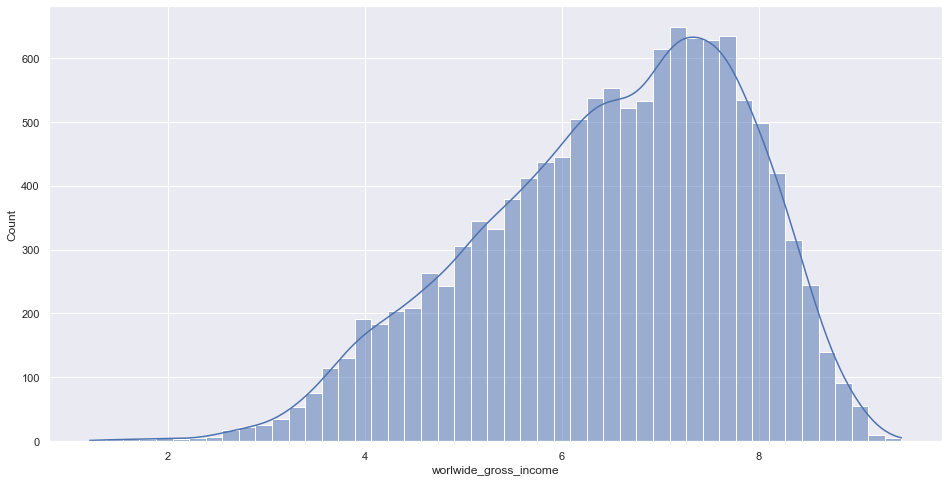

In [54]:
df_sample['worlwide_gross_income'] = log_transformation(df_sample[['worlwide_gross_income']])
sns.histplot(df_sample['worlwide_gross_income'], kde=True, edgecolor='w')

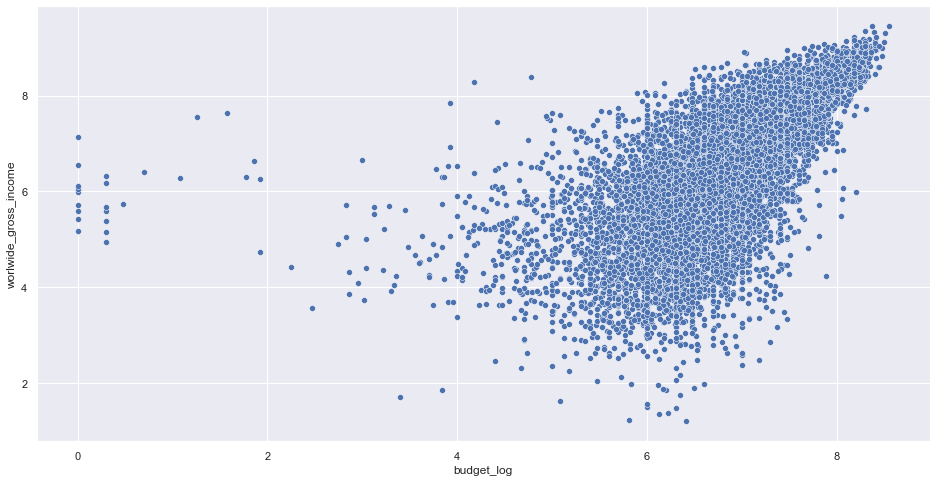

In [57]:
ax = sns.scatterplot(x=df_sample['budget_log'],y=df_sample['worlwide_gross_income'])

## Baseline

In [32]:
X_baseline = df_sample[[
        'budget',
        'duration',
        'year',
        'date_published',
    ]]
y_baseline = df_sample['worlwide_gross_income']
model_baseline = baseline.create_pipeline()

In [33]:
model_baseline = model_baseline.fit(X_baseline,y_baseline)

In [34]:
predict_y_baseline = model_baseline.predict(X_baseline)
residuals_baseline = predict_y_baseline - y_baseline

[Text(0.5, 0, 'income'), Text(0, 0.5, 'residuals')]

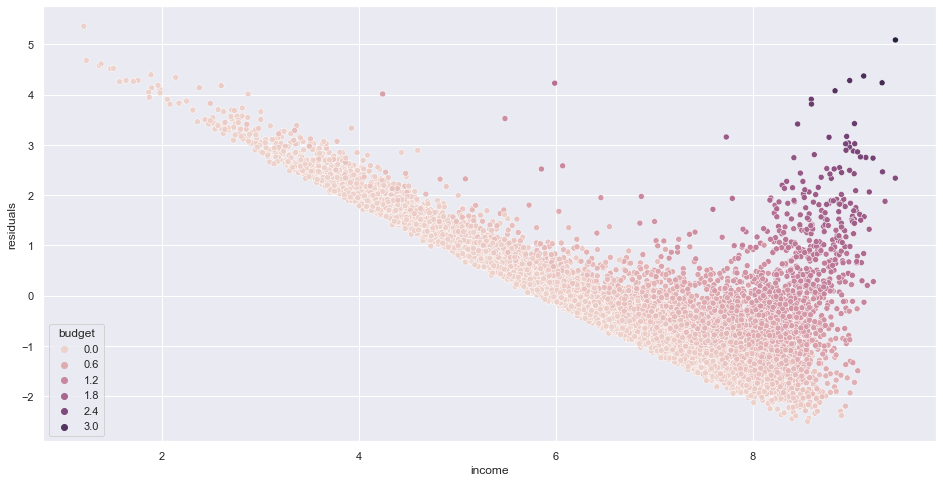

In [35]:
ax = sns.scatterplot(x=y_baseline,y=residuals_baseline, hue=df_sample['budget'])
ax.set(xlabel='income', ylabel='residuals')

## Pipeline v1

In [36]:
# Creating X and y
X_pipeline_v1 = df_sample[[
    'budget',
    'genre', 
    'duration', 
    'year', 
    'date_published',
    'production_company', 
    'writer', 
    'director'
    ]]
y_pipeline_v1 = df_sample['worlwide_gross_income']



In [37]:
model_pipeline_v1 = pipeline.create_pipeline()
model_pipeline_v1 = model_pipeline_v1.fit(X_pipeline_v1,y_pipeline_v1)
predict_y_pipeline_v1 = model_pipeline_v1.predict(X_pipeline_v1)

[Text(0.5, 0, 'budget'), Text(0, 0.5, 'residuals pipeline v1')]

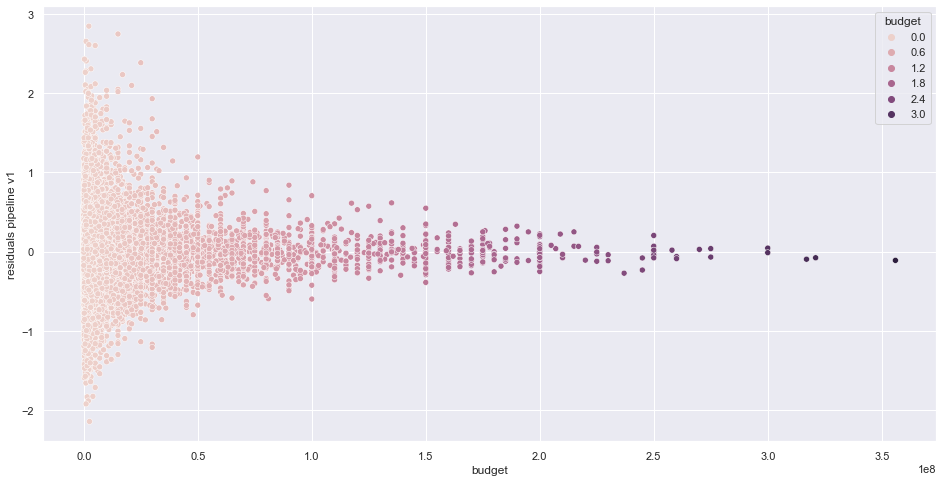

In [38]:
residuals_pipeline_v1 = predict_y_pipeline_v1 - y_pipeline_v1
ax = sns.scatterplot(x=X_pipeline_v1['budget'],y=residuals_pipeline_v1, hue=df_sample['budget'])
ax.set(xlabel='budget', ylabel='residuals pipeline v1')

[Text(0.5, 0, 'budget'), Text(0, 0.5, 'residuals pipeline v1')]

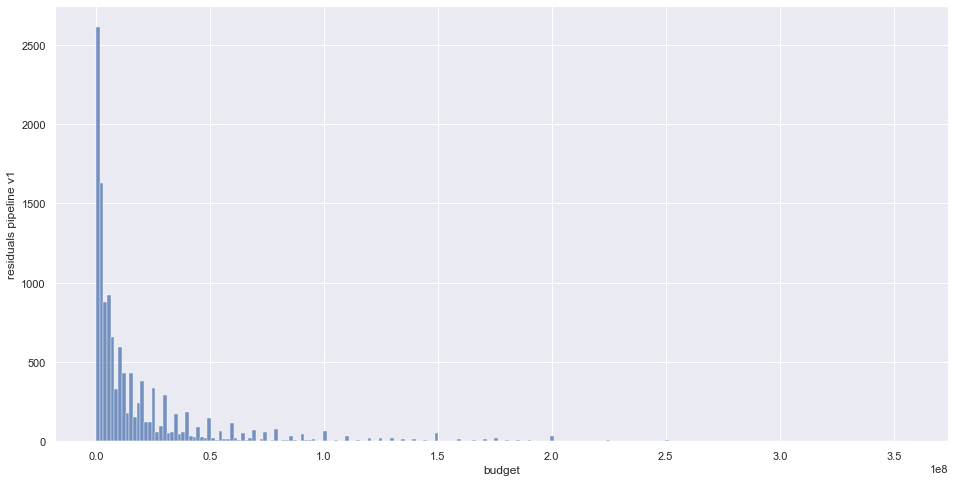

In [39]:
ax = sns.histplot(x=X_pipeline_v1['budget'])
ax.set(xlabel='budget', ylabel='residuals pipeline v1')

## Pipeline v2

In [15]:
df_sample = import_data('../raw_data/IMDb movies.csv')
#df_sample = new_model.preproc(df_sample)

In [16]:
df_sample.head(1)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0


In [17]:
print("----- IMPORT DATA ------")
df = import_data('../raw_data/IMDb movies.csv')

----- IMPORT DATA ------


In [18]:
# Prepare
print("----- CLEAN DATA ------")
df_proc = preproc(df)

----- CLEAN DATA ------


In [19]:
print("----- GET FITTED MODEL ------")
model = get_fitted_model(df_proc)

----- GET FITTED MODEL ------


In [20]:
print("----- SAVE MODEL ------")
save_model(model, "model.joblib")

----- SAVE MODEL ------


In [21]:
print("----- LOAD MODEL ------")
model = load_model("model.joblib")

----- LOAD MODEL ------


In [25]:
print("----- PREDICT MODEL ------")
prediction = predict_fromX(model, df_proc.head(1).drop(columns='worlwide_gross_income'))
print(prediction[0])

----- PREDICT MODEL ------
5.2369385
